In [20]:
from InterFaceGAN.models.stylegan_generator import StyleGANGenerator
from models.latent_optimizer import PostSynthesisProcessing
from models.image_to_latent import ImageToLatent, ImageLatentDataset
from models.losses import LogCoshLoss
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from glob import glob
from tqdm import tqdm_notebook as tqdm
import numpy as np

# Create Dataloaders
Using a 50,000 image dataset. Generated with the generated_data.py script at https://github.com/ShenYujun/InterFaceGAN.

In [2]:
augments = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_size = 256

directory = "../StyleGan/InterFaceGAN/test15/"
filenames = sorted(glob(directory + "*.jpg"))

train_filenames = filenames[0:48000]
validation_filenames = filenames[48000:]

dlatents = np.load(directory + "wp.npy")

train_dlatents = dlatents[0:48000]
validation_dlatents = dlatents[48000:]

train_dataset = ImageLatentDataset(train_filenames, train_dlatents, transforms=augments)
validation_dataset = ImageLatentDataset(validation_filenames, validation_dlatents, transforms=augments)

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32)
validation_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=32)

# Instantiate Model

In [3]:
image_to_latent = ImageToLatent(image_size).cuda()
optimizer = torch.optim.Adam(image_to_latent.parameters())
criterion = LogCoshLoss()

# Train Model

In [ ]:
epochs = 20
validation_loss = 0.0

progress_bar = tqdm(range(epochs))
for epoch in progress_bar:    
    running_loss = 0.0
    
    image_to_latent.train()
    for i, (images, latents) in enumerate(train_generator, 1):
        optimizer.zero_grad()

        images, latents = images.cuda(), latents.cuda()
        pred_latents = image_to_latent(images)
        loss = criterion(pred_latents, latents)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_description("Step: {0}, Loss: {1:4f}, Validation Loss: {2:4f}".format(i, running_loss / i, validation_loss))
    
    validation_loss = 0.0
    
    image_to_latent.eval()
    for i, (images, latents) in enumerate(validation_generator, 1):
        with torch.no_grad():
            images, latents = images.cuda(), latents.cuda()
            pred_latents = image_to_latent(images)
            loss =  criterion(pred_latents, latents)
            
            validation_loss += loss.item()
    
    validation_loss /= i
    progress_bar.set_description("Step: {0}, Loss: {1:4f}, Validation Loss: {2:4f}".format(i, running_loss / i, validation_loss))

# Save Model

In [5]:
torch.save(image_to_latent.state_dict(), "./image_to_latent.pt")

# Load Model

In [7]:
image_to_latent = ImageToLatent(image_size).cuda()
image_to_latent.load_state_dict(torch.load("image_to_latent.pt"))
image_to_latent.eval()

ImageToLatent(
  (activation): ELU(alpha=1.0)
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Test Model

In [62]:
def normalized_to_normal_image(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1).float()
    std=torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1).float()
    
    image = image.detach().cpu()
    
    image *= std
    image += mean
    image *= 255
    
    image = image.numpy()[0]
    image = np.transpose(image, (1,2,0))
    return image.astype(np.uint8)


num_test_images = 5
images = [validation_dataset[i][0].unsqueeze(0).cuda() for i in range(num_test_images)]
normal_images = list(map(normalized_to_normal_image, images))

pred_dlatents = map(image_to_latent, images)

synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

pred_images = map(synthesizer, pred_dlatents)
pred_images = map(post_process, pred_images)
pred_images = list(map(lambda image: np.transpose(image, (1,2,0)), pred_images))

[2019-11-28 21:45:04,745][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2019-11-28 21:45:04,814][INFO] Successfully loaded!
[2019-11-28 21:45:04,815][INFO]   `lod` of the loaded model is 0.0.


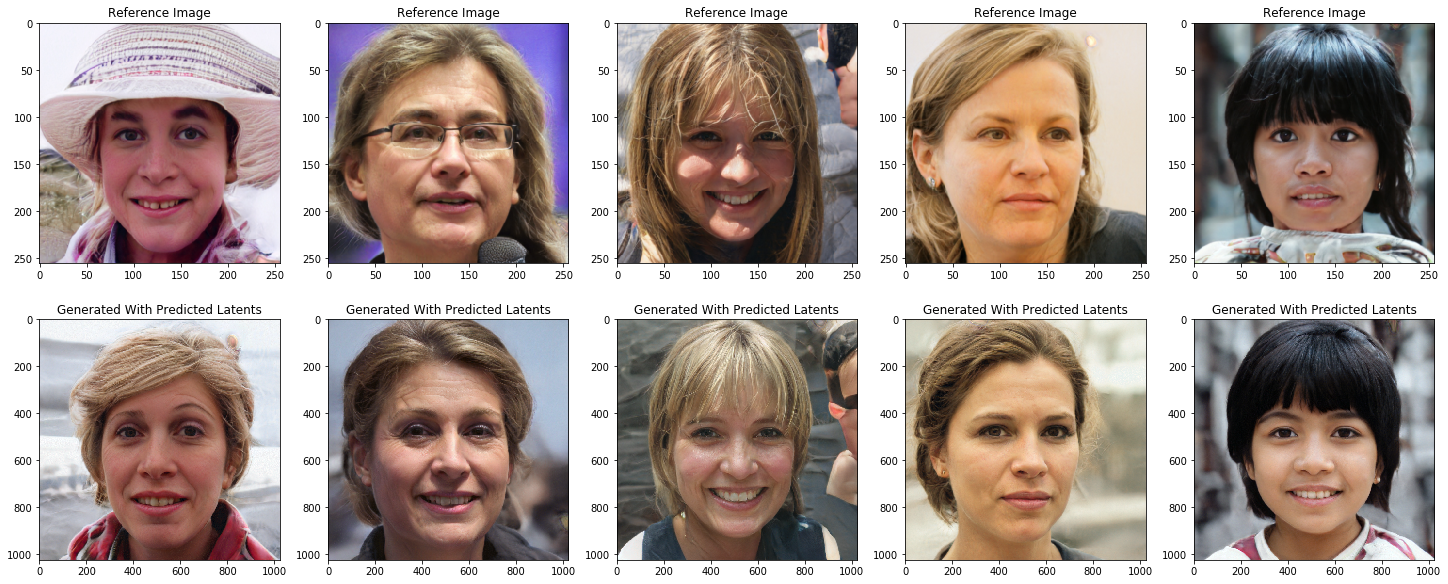

In [65]:
figure = plt.figure(figsize=(25,10))
columns = len(normal_images)
rows = 2

axis = []

for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])

for i in range(columns, columns*rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(pred_images[i - columns])

plt.show()